## Extract tables from docx files

In [2]:
import re
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmatized_words)

In [3]:
from docx import Document
import json


def extract_data(file_path):
    doc = Document(file_path)
    data = []
    date = doc.paragraphs[1].text.strip()
    date = re.sub(r'[а-яА-Я\s]', '', date)
    for table in doc.tables:
        for row in table.rows[1:]:  # Пропускаем заголовок
            cells = row.cells
            if cells[2].text.strip() == "" or cells[3].text.strip() == "":
                continue
            if "костюм" in preprocess_text(cells[0].text.strip()):
                type_clothes = "костюм"
            else:
                type_clothes = "other"
            
            item = {
                "id": len(data) + 1,  # Генерация ID
                "name": cells[0].text.strip(),
                "type":type_clothes,
                "date":date,
                "description": preprocess_text(f"{cells[0].text.strip()} {cells[1].text.strip()} {cells[2].text.strip()}"),
                "price": cells[3].text.strip(),  # Преобразуем в число
                "currency": "руб.",
                "source": file_path
            }
            data.append(item)
    
    return data

In [4]:
# Сохранение в JSON
import os 
from pathlib import Path


docs = os.listdir('datasets_raw/КП_тест')
for doc in docs:
    filepath = f"КП_тест/{doc}"
    data = extract_data(filepath)
    if data!=[]:
        with open(f"json_db/{Path(filepath).stem}.json", "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2, ensure_ascii=False)


PackageNotFoundError: Package not found at 'КП_тест/НУБК_3_КП для летний по образцу.docx'

## GET JSONS

In [5]:
from dotenv import load_dotenv
import os
import json
import openai
import pandas as pd
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from langchain_community.document_loaders import UnstructuredFileLoader

load_dotenv()

True

In [7]:
def extract_text_from_file(file_path):
    text_data = []
    try:
        loader = UnstructuredFileLoader(file_path)
        docs = loader.load()
        text_data.append("\n\n".join([doc.page_content for doc in docs]))
    except Exception as e:
        print(f"⚠️ Ошибка при обработке {file_path}: {e}")

    return "\n\n".join(text_data)

def convert_to_json(text):
    prompt = f"""
        Ты получишь текстовые данные с описанием товаров и их цен. Это таблица.  
        Верни json структуру:
        [
        {{
            "id": int,  # Генерация ID, уникального для каждого товара в таблице
            "name": string, # наименование товара, в тексте это представлено как коротное описание
            "description": string, # полное описание товара
            "price": float,  # Преобразуем в число # цена товара
            "currency": "руб." # одинаковая для всех товаров, не зависит от текста
        }}
        ]
       
        Правила обработки:
        - Верни данные в формате json
        - Придумай уникальный ID для каждого товара
        - Преобразуй цену в число
        - Преобразуй текст в нижний регистр
        - Удали лишние пробелы
        - Лемматизируй текст
        
        Важно:
        Анализируй заголовки таблиц и извлекай данные корректно.
        Соблюдай указанную структуру без лишний слов. Ответ должен содержать ТОЛЬКО json структуру.

        Вот данные:
        {text}
    """
    
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
    response = llm([HumanMessage(content=prompt)])
    return response.content.strip("```json").strip("```")

def process_files(dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for file_name in os.listdir(dir):
        file_path = os.path.join(dir, file_name)
        text_data = extract_text_from_file(file_path)
        json_data = convert_to_json(text_data)
    
        #return json_data
        output_file = os.path.splitext(f'{output_dir}/{file_name}')[0]+'.json'

        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(json.loads(json_data), f, indent=4, ensure_ascii=False)
        print(f"✅ Данные сохранены в {output_file}!")

In [8]:
process_files("datasets_raw/КП_тест", "datasets_json/json_test_kp")

/tmp/ipykernel_64489/1900793125.py:4: LangChainDeprecationWarning: The class `UnstructuredFileLoader` was deprecated in LangChain 0.2.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-unstructured package and should be used instead. To use it run `pip install -U :class:`~langchain-unstructured` and import as `from :class:`~langchain_unstructured import UnstructuredLoader``.
  loader = UnstructuredFileLoader(file_path)
/tmp/ipykernel_64489/1900793125.py:42: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
/tmp/ipykernel_64489/1900793125.py:43: LangChainDeprecationWarning: The method `BaseCha

✅ Данные сохранены в datasets_json/json_test_kp/НУБК_3_КП для летний по образцу.json!
✅ Данные сохранены в datasets_json/json_test_kp/Евракор_3_КП для Евракор.json!


/home/wormsin/miniconda3/envs/genai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Данные сохранены в datasets_json/json_test_kp/Масло Март_4_КП.json!
✅ Данные сохранены в datasets_json/json_test_kp/Пакер-Сервис_3_КП.json!
✅ Данные сохранены в datasets_json/json_test_kp/НТК_2_Форма подачи КП.json!
✅ Данные сохранены в datasets_json/json_test_kp/КП_спецодежда_БерезкаГаз_Швецъ_03.02.25.json!
✅ Данные сохранены в datasets_json/json_test_kp/КП_спецодежда_СК_ЮВиС_Швецъ.json!
✅ Данные сохранены в datasets_json/json_test_kp/КП_спецодежда_Швецъ_СИНЕРГИЯ.json!
✅ Данные сохранены в datasets_json/json_test_kp/КП ШВЕЦЪ.json!
✅ Данные сохранены в datasets_json/json_test_kp/КП ШВЕЦЪ_.json!
✅ Данные сохранены в datasets_json/json_test_kp/КП_Швецъ_спеодежда_для_Аминосиб.json!


## vector db

In [ ]:
from langchain.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from uuid import uuid4
from langchain.document_loaders import JSONLoader



def metadata_func(record: dict, metadata: dict) -> dict:
    metadata["name"] = record.get("name")
    metadata["price"] = record.get("price")
    metadata["currency"] = record.get("currency")
    metadata["type"] = record.get("type")
    metadata["date"] = record.get("date")

    return metadata


uuids = [str(uuid4()) for _ in range(len(os.listdir("json_db")))]
docs = []
for file in os.listdir("json_db"):

    file_name = "json_db/" + file

    loader = JSONLoader(
        file_path=file_name,
        jq_schema=".[]",
        content_key="description",
        metadata_func=metadata_func
        #text_content=False
    )
    document = loader.load()
    docs += document


In [7]:
from langchain_chroma import Chroma

model_name = "DeepPavlov/rubert-base-cased"
embedding_model = HuggingFaceEmbeddings(model_name = "intfloat/multilingual-e5-base")

vector_store = Chroma(
    collection_name="json_collection",
    embedding_function=embedding_model,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

/tmp/ipykernel_20771/3572408945.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name = "intfloat/multilingual-e5-base")
/home/wormsin/miniconda3/envs/genai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
uuids = [str(uuid4()) for _ in range(len(docs))]

In [ ]:
vector_store.add_documents(documents=docs, ids = uuids)

## Retriever

In [16]:
retriever = vector_store.as_retriever(search_type = "mmr", search_kwargs={"filter": {"type": "костюм"}})

In [11]:
def format_docs(docs):
    return "\n\n".join([f"Date: {doc.metadata['date']}\nPrice: {doc.metadata['price'] + doc.metadata['currency']}\nContent: {doc.page_content}" for doc in docs])

## RAG chain

In [19]:
from dotenv import load_dotenv
load_dotenv()

True

In [29]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name = "gpt-4o-mini")

In [37]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


template = """
Задача:
Оценить цену нового продукта на основе предоставленного контекста.

Инструкции:
Пользователь предоставит описание нового продукта.
Вам нужно будет использовать цены существующих продуктов из поля "Price" и их описания из поля "Content".
Поле "Date" указывает, когда продукт был предложен по указанной цене.
Если указана дата, скорректируйте цену с учётом инфляции, увеличив цену на 10% за каждый год в зависимости от разницы между текущей датой и датой контекста.
Если поле "Date" отсутствует или пустое, не вносите изменений в цену.
Чётко объясните, какие параметры повлияли на оценочную цену(перечисли определенные характеристика изделия, если таковые есть и их влияние) 
и как (например, увеличили или уменьшили стоимость).
Предоставьте конкретную числовую цену, если это возможно, с учётом инфляции, если это применимо.
Если точную цену определить невозможно, чётко объясните, почему, какие дополнительные данные нужны и какие параметры отсутствуют.
Не выдумывайте информацию. Если в контексте нет релевантных данных, просто ответьте: "Я не знаю." с указанием причины. 


<context>
{context}
</context>

question: {question}

"""
prompt = PromptTemplate(input_variables=["context", "question"], template=template)

llm_chain = prompt | llm | StrOutputParser()

In [34]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

rag_chain = {"context":retriever | RunnableLambda(format_docs), "question": RunnablePassthrough()} | llm_chain

In [35]:
description = """КУРТКА:
- прямого силуэта
- с центральной супатной застёжкой на пять пуговиц и две сквозные вверху борта
- полочки и спинка с кокетками из отделочной ткани
- по кокеткам проложена СОП шириной 50 мм
- полочки с накладными карманами: одним верхними на левой полочке и двумя нижними
- верхний накладной карман с клапаном, застёгивающимся на ленты контакт
- нижние накладные карманы с наклонным входом
- рукава втачные, с трикотажной манжетой"""


In [ ]:
print(rag_chain.invoke(description))

Для оценки цены нового продукта — куртки, описанной вами, я рассмотрел предоставленный контекст и выбрал наиболее подходящие существующие продукты.

1. **Первый продукт:** Женский костюм "бренд 1"
   - **Цена:** 3010 руб.
   - **Дата:** 03.04.2023
   - **Описание:** Женский костюм с курткой, в описании упоминаются элементы, такие как застёжка на молнию, карманы и использование смесовых тканей, но кроме этого, куртка имеет значительное количество деталей, которые отличаются от вашего описания.

2. **Второй продукт:** Костюм сварщика 3 кл.
   - **Цена:** 10620 руб.
   - **Дата:** 26.01.2023
   - **Описание:** Костюм с защитными элементами, выполненный из 100% хлопка, что делает его более специализированным изделием. Цена здесь значительно выше, чем у других костюмов.

3. **Третий продукт:** Костюм «стандарт»
   - **Цена:** 1200 руб.
   - **Дата:** 31.03.2023
   - **Описание:** Простая куртка и брюки, но тоже не соответствует требованиям, указанным в вашем новом описании.

4. **Четвёртый 

## test price prediction

In [10]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

In [22]:
def format_docs(docs):
    return "\n\n".join([f"Date: {doc.metadata['date']}\nPrice: {doc.metadata['price'] + doc.metadata['currency']}\nContent: {doc.page_content}" for doc in docs])


embedding_model = HuggingFaceEmbeddings(model_name = "intfloat/multilingual-e5-base")
vector_store = Chroma(embedding_function=embedding_model, collection_name = "json_collection", persist_directory="./chroma_langchain_db")

retriever = vector_store.as_retriever(search_type = "mmr", search_kwargs={"filter": {"type": "костюм"}})

llm = ChatOpenAI(model_name = "o1-mini")

template = """
Задача:
Оценить цену нового продукта на основе предоставленного контекста.

Инструкции:
Сейчас февраль 2025 года. 
Пользователь предоставит описание нового продукта. 
Вам нужно будет использовать цены существующих продуктов из поля "Price" и их описания из поля "Content".
Поле "Date" указывает, когда продукт был предложен по указанной цене.
Если указана дата, скорректируйте цену с учётом инфляции, увеличив цену на 10% за каждый год в зависимости от разницы между текущей датой и датой контекста.
Если поле "Date" отсутствует или пустое, не вносите изменений в цену.
Проанализируй, какие параметры повлияли на оценочную цену(перечисли определенные характеристика изделия(виды ткани и т.д.), если таковые есть и их влияние) 
и как (например, увеличили или уменьшили стоимость).
Предоставьте конкретную числовую цену. Ответ должен быть в рублях и содержать конкретное число.
Не выдумывайте информацию. Если в контексте нет релевантных данных, ответь 0. Ответ содержит только число без каких-либо дополнительных слов в формате "122.12".


<context>
{context}
</context>

question: {question}

"""
prompt = PromptTemplate(input_variables=["context", "question"], template=template)

llm_chain = prompt | llm | StrOutputParser()

rag_chain = {"context":retriever | RunnableLambda(format_docs), "question": RunnablePassthrough()} | llm_chain

In [32]:
import json
from pathlib import Path

def process_json(file_path, rag_chain):
    # Загружаем JSON-файл
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    
    # Проверяем, является ли загруженный JSON списком
    if not isinstance(data, list):
        raise ValueError("JSON должен содержать список товаров")
    
    # Обрабатываем каждый товар
    for item in data:
        name = item.get("name", "")
        description = item.get("description", "")
        
        # Отправляем данные в RAG-модель
        response = rag_chain.invoke(name + description)
        response = float(response.replace(",", ".").strip())
        
        # Записываем предсказанную цену
        item["prediction_price"] = response
    
    # Записываем обновленный JSON обратно в файл
    output_path = "datasets_json/json_kp_test_result/"+Path(file_path).stem + "_processed.json"
    with open(output_path, "w", encoding="utf-8") as file:
        json.dump(data, file, indent=4, ensure_ascii=False)
    
    print(f"Обработанный JSON сохранен в {output_path}")

# Пример использования:
# process_json("products.json", rag_chain)

In [25]:
files = os.listdir("datasets_json/json_test_kp")[-3:]


In [26]:
files

['КП ШВЕЦЪ.json', 'КП ШВЕЦЪ_.json', 'КП_Швецъ_спеодежда_для_Аминосиб.json']

In [34]:
for file_name in files:
    process_json(f"datasets_json/json_test_kp/{file_name}", rag_chain)

Обработанный JSON сохранен в datasets_json/json_kp_test_result/КП ШВЕЦЪ_processed.json


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

## result analysis

In [4]:
import json
import matplotlib.pyplot as plt
from pathlib import Path
import os

def extract_prices(json_files):
    actual_prices = []
    predicted_prices = []
    labels = []
    
    for file_path in json_files:
        with open(file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
            for item in data:
                if item.get("prediction_price", 0) == 0 or item.get("price", 0) == 0:
                    continue
                labels.append(item.get("name", "Unknown"))
                actual_prices.append(item.get("price", 0))
                predicted_prices.append(item.get("prediction_price", 0))
    
    return labels, actual_prices, predicted_prices


In [5]:
labels, actual_prices, predicted_prices = extract_prices(["datasets_json/json_kp_test_result/"+file for file in os.listdir("datasets_json/json_kp_test_result")])

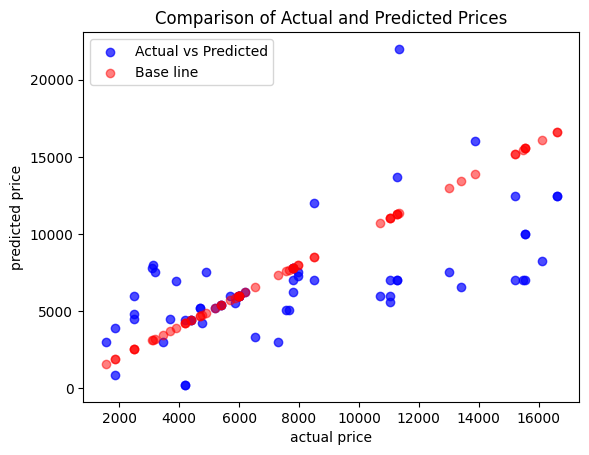

In [6]:
x = range(len(labels))
plt.scatter(actual_prices,predicted_prices, label='Actual vs Predicted', color='blue', alpha=0.7)
plt.scatter(actual_prices, actual_prices, label='Base line', color='red', alpha=0.5)
plt.ylabel("predicted price")
plt.xlabel("actual price")
plt.title("Comparison of Actual and Predicted Prices")
plt.legend()
plt.show()  

/tmp/ipykernel_24593/1670442570.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


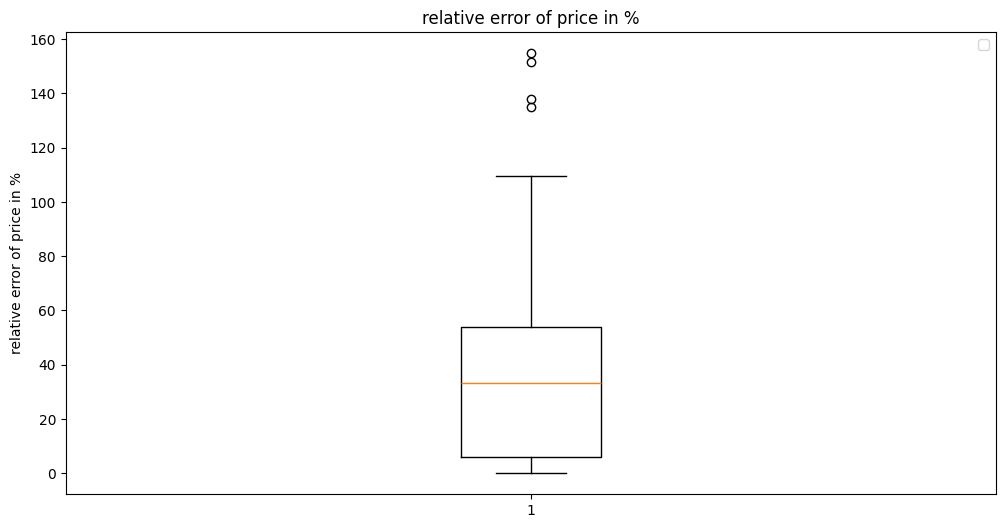

In [7]:
import numpy as np

actual_prices = np.array(actual_prices)
predicted_prices = np.array(predicted_prices)
error = actual_prices - predicted_prices
relative_error = np.abs(actual_prices - predicted_prices) / actual_prices * 100

x = range(len(labels))
plt.figure(figsize=(12, 6))
plt.boxplot(relative_error)

plt.ylabel("relative error of price in %")
plt.title("relative error of price in %")
plt.legend()
plt.show()

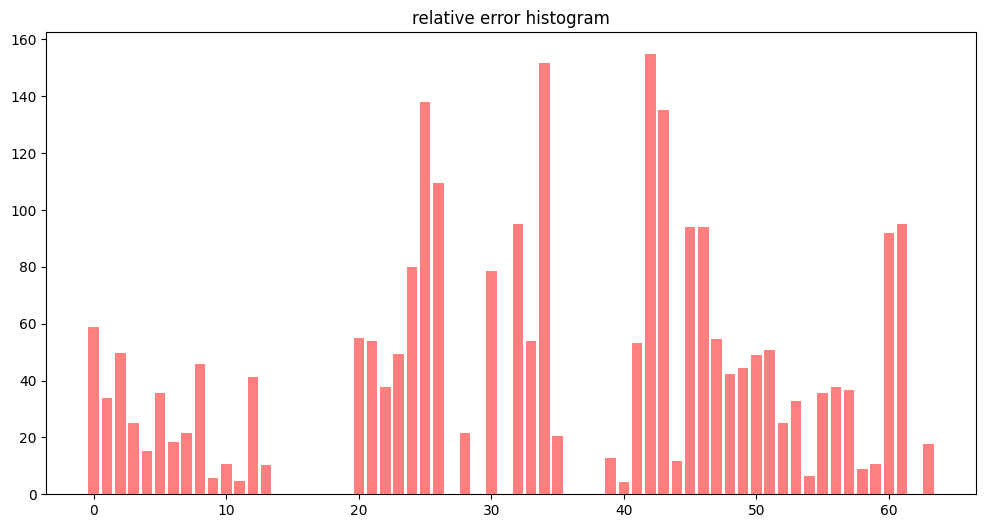

In [111]:
plt.figure(figsize=(12, 6))
plt.bar(x, relative_error, color='red', alpha=0.5)
plt.title("relative error histogram")
plt.show()


In [15]:
print("число примеров", len(error))
print("средняя абсолютная ошибка", np.sum(np.abs(error))/len(error))
print("средняя отностительная ошибка", np.sum(relative_error)/len(relative_error))

число примеров 64
средняя абсолютная ошибка 2737.265625
средняя отностительная ошибка 39.39167975981253


число примеров 27
средняя ошибка 1606.4074074074074


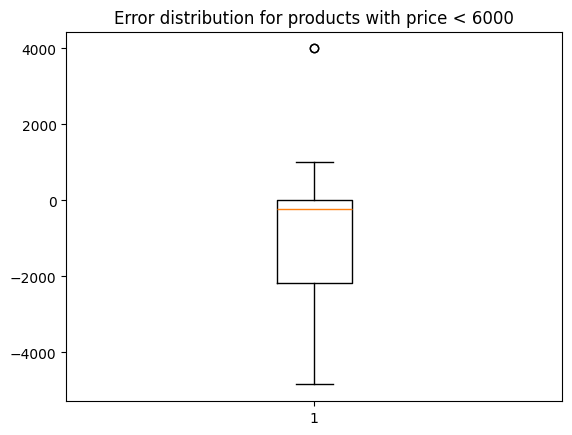

In [17]:
print("число примеров", len(error[actual_prices<6000]))

print("средняя ошибка", np.sum(np.abs(error[actual_prices<6000]))/len(error[actual_prices<6000]))

plt.boxplot(error[actual_prices<6000]);

plt.title("Error distribution for products with price < 6000");

число примеров 37
средняя ошибка 3562.4864864864867


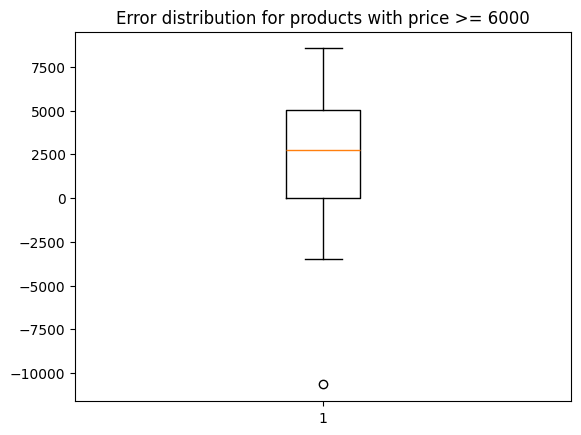

In [14]:
print("число примеров", len(error[actual_prices>=6000]))

print("средняя ошибка", np.sum(np.abs(error[actual_prices>=6000]))/len(error[actual_prices>=6000]))

plt.boxplot(error[actual_prices>=6000]);

plt.title("Error distribution for products with price >= 6000");